#Data Preprocessing

In [25]:
import os
import glob
import time
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms, models
import kagglehub

from scipy.optimize import minimize_scalar
from scipy.stats import binom

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

EPSILON_PAC = 0.10
DELTA_PAC = 0.05

RACE_GROUPS = {
    0: "White",
    1: "Black",
    2: "Asian",
    3: "Indian",
    4: "Others"
}
NUM_RACE_GROUPS = len(RACE_GROUPS)
SENSITIVE_ATTR_NAME = "Race"

# Age prediction classification
AGE_BINS = [(0, 9), (10, 19), (20, 29), (30, 39), (40, 49),
            (50, 59), (60, 69), (70, 79), (80, 89), (90, 116)] # Max age in UTKFace is ~116
NUM_AGE_CLASSES = len(AGE_BINS)
PREDICTION_TASK_NAME = "Age Range"

def age_to_class(age):
    for i, (lower, upper) in enumerate(AGE_BINS):
        if lower <= age <= upper:
            return i
    return None


Using device: cuda


In [2]:
dataset_handle = "moritzm00/utkface-cropped"
dataset_image_folder = None
try:
    print(f"Downloading dataset '{dataset_handle}' using KaggleHub...")
    dataset_path_from_hub = kagglehub.dataset_download(dataset_handle)
    print(f"Dataset downloaded to: {dataset_path_from_hub}")
    dataset_image_folder = os.path.join(dataset_path_from_hub, "UTKFace")
except Exception as e:
    print(f"Error downloading or accessing dataset via KaggleHub: {e}"); raise

if dataset_image_folder:
    image_files_final_check = glob.glob(os.path.join(dataset_image_folder, "*.jpg"))
    if not image_files_final_check: print(f"CRITICAL ERROR: No JPG files found in '{dataset_image_folder}'.")
    else: print(f"Found {len(image_files_final_check)} images in '{dataset_image_folder}'.")
else: raise FileNotFoundError("dataset_image_folder was not set.")

Dataset downloaded to: /kaggle/input/utkface-cropped
Found 23708 images in '/kaggle/input/utkface-cropped/UTKFace'.


In [3]:
IMG_SIZE = 224
BATCH_SIZE = 32

# For gender classificaiton
class UTKFaceGenderRaceDataset(Dataset):
    def __init__(self, transform=None, file_list=None, gender_labels=None, race_labels=None):
        self.transform = transform
        self.image_files = file_list
        self.gender_labels = gender_labels
        self.race_labels = race_labels

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        gender_label = self.gender_labels[idx]
        race_label = self.race_labels[idx]

        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(gender_label, dtype=torch.long), torch.tensor(race_label, dtype=torch.long)

# Parse all data initially
def parse_all_utkface_data(image_folder_path):
    all_image_paths = []
    all_gender_labels = []
    all_race_labels = []
    raw_files_from_folder = glob.glob(os.path.join(image_folder_path, "*.jpg"))
    for img_path in raw_files_from_folder:
        try:
            filename = os.path.basename(img_path)
            name_part = filename.split('.')[0]
            parts = name_part.split('_')
            # Filename: age_gender_race_datetime.jpg or age_gender_race.jpg
            if len(parts) >= 3:
                gender = int(parts[1])
                race = int(parts[2])
                if gender in [0, 1] and race in RACE_GROUPS.keys():
                    all_image_paths.append(img_path)
                    all_gender_labels.append(gender)
                    all_race_labels.append(race)

        except (ValueError, IndexError) as e:
            pass
    return all_image_paths, all_gender_labels, all_race_labels

all_paths, all_targets, all_races = parse_all_utkface_data(dataset_image_folder)

In [4]:
# For age
class UTKFaceAgeRaceDataset(Dataset):
    def __init__(self, transform=None, file_list=None, age_class_labels=None, race_labels=None):
        self.transform = transform
        self.image_files = file_list
        self.age_class_labels = age_class_labels
        self.race_labels = race_labels

        if not self.image_files:
            print(f"WARNING: Image file list empty for this dataset split.")


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error opening image {img_path}: {e}. Returning a dummy red image.")
            image = Image.new('RGB', (IMG_SIZE, IMG_SIZE), color = 'red')

        age_class_label = self.age_class_labels[idx]
        race_label = self.race_labels[idx]

        if self.transform:
            image = self.transform(image)

        if age_class_label is None:
            print(f"Warning: age_class_label is None for image {img_path}. Returning -1 as label.")
            return image, torch.tensor(-1, dtype=torch.long), torch.tensor(race_label, dtype=torch.long)

        return image, torch.tensor(age_class_label, dtype=torch.long), torch.tensor(race_label, dtype=torch.long)

def parse_all_utkface_data_for_age(image_folder_path):
    all_image_paths = []
    all_age_class_labels = []
    all_race_labels = []
    raw_files_from_folder = glob.glob(os.path.join(image_folder_path, "*.jpg"))
    skipped_due_to_age_bin = 0
    for img_path in raw_files_from_folder:
        try:
            filename = os.path.basename(img_path)
            name_part = filename.split('.')[0]
            parts = name_part.split('_')
            if len(parts) >= 3:
                age_val = int(parts[0])
                race_val = int(parts[2])

                age_class = age_to_class(age_val)

                if age_class is not None and race_val in RACE_GROUPS.keys():
                    all_image_paths.append(img_path)
                    all_age_class_labels.append(age_class)
                    all_race_labels.append(race_val)
                elif age_class is None:
                    skipped_due_to_age_bin +=1

        except (ValueError, IndexError) as e:
            pass
    print(f"Total usable images parsed with age class and race: {len(all_image_paths)}")
    if skipped_due_to_age_bin > 0:
        print(f"Skipped {skipped_due_to_age_bin} images because age was outside defined AGE_BINS.")
    if not all_image_paths:
        raise ValueError("No usable images found after parsing for age class and race.")
    return all_image_paths, all_age_class_labels, all_race_labels

all_paths, all_targets, all_races = parse_all_utkface_data_for_age(dataset_image_folder)

Total usable images parsed with age class and race: 23705


In [5]:
from sklearn.model_selection import train_test_split

common_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10), transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
    transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

utk_data = list(zip(all_paths, all_targets, all_races))
stratify_labels_for_z_val = all_races

conf_set_val_ratio = 0.20
temp_data_ratio = 1.0 - conf_set_val_ratio

temp_indices, conf_set_val_indices = train_test_split(
    list(range(len(utk_data))),
    test_size=conf_set_val_ratio,
    stratify=stratify_labels_for_z_val,
    random_state=42
)

main_train_abs_ratio_of_temp = (0.60 / temp_data_ratio)
main_val_abs_ratio_of_temp = (0.10 / temp_data_ratio)

conf_set_val_files = [all_paths[i] for i in conf_set_val_indices]
conf_set_val_targets = [all_targets[i] for i in conf_set_val_indices]
conf_set_val_races = [all_races[i] for i in conf_set_val_indices]

temp_paths = [all_paths[i] for i in temp_indices]
temp_targets = [all_targets[i] for i in temp_indices]
temp_races = [all_races[i] for i in temp_indices]

val_calib_combined_size_from_temp = main_val_abs_ratio_of_temp + (1.0 - main_train_abs_ratio_of_temp - main_val_abs_ratio_of_temp)

main_train_temp_indices, val_calib_temp_indices = train_test_split(
    list(range(len(temp_paths))),
    test_size=val_calib_combined_size_from_temp,
    stratify=temp_races,
    random_state=42
)

main_train_files = [temp_paths[i] for i in main_train_temp_indices]
main_train_targets = [temp_targets[i] for i in main_train_temp_indices]
main_train_races = [temp_races[i] for i in main_train_temp_indices]

val_calib_paths = [temp_paths[i] for i in val_calib_temp_indices]
val_calib_targets = [temp_targets[i] for i in val_calib_temp_indices]
val_calib_races = [temp_races[i] for i in val_calib_temp_indices]

calib_tau_rel_ratio = (1.0 - main_val_abs_ratio_of_temp / val_calib_combined_size_from_temp) if val_calib_combined_size_from_temp > 0 and main_val_abs_ratio_of_temp <= val_calib_combined_size_from_temp else 0.5


main_val_vc_indices, calib_tau_vc_indices = train_test_split(
    list(range(len(val_calib_paths))),
    test_size=calib_tau_rel_ratio,
    stratify=val_calib_races,
    random_state=42
)

main_val_files = [val_calib_paths[i] for i in main_val_vc_indices]
main_val_targets = [val_calib_targets[i] for i in main_val_vc_indices]
main_val_races = [val_calib_races[i] for i in main_val_vc_indices]

calib_tau_files = [val_calib_paths[i] for i in calib_tau_vc_indices]
calib_tau_targets = [val_calib_targets[i] for i in calib_tau_vc_indices]
calib_tau_races = [val_calib_races[i] for i in calib_tau_vc_indices]

main_train_dataset = UTKFaceAgeRaceDataset(transform=train_transform, file_list=main_train_files, age_class_labels=main_train_targets, race_labels=main_train_races)
main_val_dataset = UTKFaceAgeRaceDataset(transform=common_transform, file_list=main_val_files, age_class_labels=main_val_targets, race_labels=main_val_races)
calib_tau_dataset = UTKFaceAgeRaceDataset(transform=common_transform, file_list=calib_tau_files, age_class_labels=calib_tau_targets, race_labels=calib_tau_races)
conf_set_val_dataset = UTKFaceAgeRaceDataset(transform=common_transform, file_list=conf_set_val_files, age_class_labels=conf_set_val_targets, race_labels=conf_set_val_races)

print(f"\nDataset sizes after splitting:")
print(f"  Main train dataset size: {len(main_train_dataset)}")
print(f"  Main val dataset size: {len(main_val_dataset)}")
print(f"  Calib tau dataset (Z'_train) size: {len(calib_tau_dataset)}")
print(f"  Conf set val dataset (Z_val) size: {len(conf_set_val_dataset)}")

main_train_loader = DataLoader(main_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
main_val_loader = DataLoader(main_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
calib_tau_loader = DataLoader(calib_tau_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
conf_set_val_loader = DataLoader(conf_set_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

if conf_set_val_dataset and len(conf_set_val_dataset) > 0:
    print("\nDistribution of groups in Z_val (conf_set_val_dataset):")
    race_counts_z_val = pd.Series(conf_set_val_dataset.race_labels).value_counts().sort_index()
    for race_idx, count in race_counts_z_val.items():
        print(f"  Group {RACE_GROUPS[race_idx]} (ID {race_idx}): {count} samples")
    if race_counts_z_val.min() < 10:
        print("WARNING: Some groups in Z_val have very few samples, which might affect PAC bound reliability for those groups.")


Dataset sizes after splitting:
  Main train dataset size: 14222
  Main val dataset size: 2370
  Calib tau dataset (Z'_train) size: 2372
  Conf set val dataset (Z_val) size: 4741

Distribution of groups in Z_val (conf_set_val_dataset):
  Group White (ID 0): 2016 samples
  Group Black (ID 1): 905 samples
  Group Asian (ID 2): 687 samples
  Group Indian (ID 3): 795 samples
  Group Others (Hispanic, Latino, Middle Eastern) (ID 4): 338 samples


# Algorithm 1

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s]



--- Training Base Model (f_phi) ---

Epoch 1/12
----------
Train Loss: 1.2698 Acc: 0.5043
Val Loss: 1.0953 Acc: 0.5557
New best val acc for f_phi: 0.5557. Model saved.

Epoch 2/12
----------
Train Loss: 1.0457 Acc: 0.5726
Val Loss: 1.0042 Acc: 0.5692
New best val acc for f_phi: 0.5692. Model saved.

Epoch 3/12
----------
Train Loss: 0.9652 Acc: 0.5994
Val Loss: 0.9774 Acc: 0.5873
New best val acc for f_phi: 0.5873. Model saved.

Epoch 4/12
----------
Train Loss: 0.8962 Acc: 0.6340
Val Loss: 0.9903 Acc: 0.5848

Epoch 5/12
----------
Train Loss: 0.8314 Acc: 0.6602
Val Loss: 1.0397 Acc: 0.5650

Epoch 6/12
----------
Train Loss: 0.7756 Acc: 0.6803
Val Loss: 1.0544 Acc: 0.5819

Epoch 7/12
----------
Train Loss: 0.7003 Acc: 0.7180
Val Loss: 1.0797 Acc: 0.5831

Epoch 8/12
----------
Train Loss: 0.6487 Acc: 0.7405
Val Loss: 1.1326 Acc: 0.5477

Epoch 9/12
----------
Train Loss: 0.5635 Acc: 0.7813
Val Loss: 1.2077 Acc: 0.5570

Epoch 10/12
----------
Train Loss: 0.5032 Acc: 0.8058
Val Loss: 1.27

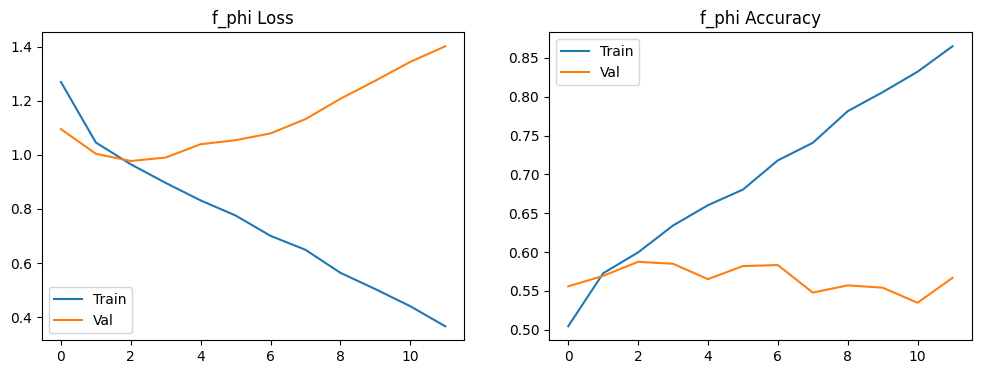


--- Calibrating Global Temperature (tau) using Z'_train (calib_tau_loader) ---
Optimizing tau...
 message: Solution found.
 success: True
  status: 0
     fun: 0.9797418378858904
       x: 0.9527596002270514
     nit: 17
    nfev: 17
Optimized tau = 0.9528
Final OPTIMIZED_TAU value to be used: 0.9528

--- NLL for various tau values (using pre-collected logits) ---
  NLL tau=0.10: 1.867994
  NLL tau=0.50: 1.101260
  NLL tau=0.80: 0.989298
  NLL tau=0.90: 0.980776
  NLL tau=1.00: 0.980502
  NLL tau=1.10: 0.986552
  NLL tau=1.20: 0.997576
  NLL tau=1.50: 1.051889
  NLL tau=2.00: 1.185261
  NLL tau=5.00: 2.306273


In [6]:
model_phi = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model_phi.fc.in_features
model_phi.fc = nn.Linear(num_ftrs, NUM_AGE_CLASSES)
model_phi = model_phi.to(device)

criterion_phi = nn.CrossEntropyLoss()
optimizer_phi = optim.Adam(model_phi.parameters(), lr=0.0001)
scheduler_phi = optim.lr_scheduler.StepLR(optimizer_phi, step_size=7, gamma=0.1)
NUM_EPOCHS_PHI = 12

def train_base_model_target(model, criterion, optimizer, scheduler, num_epochs, train_loader, val_loader):
    since = time.time();
    best_model_wts = model.state_dict();
    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    print(f"\n--- Training Base Model (f_phi) ---")
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}'); print('-' * 10)
        for phase in ['train', 'val']:
            current_loader = train_loader if phase == 'train' else val_loader
            if current_loader is None or len(current_loader.dataset) == 0:
                print(f"Skipping {phase} as loader is empty."); history[f'{phase}_loss'].append(float('nan')); history[f'{phase}_acc'].append(float('nan')); continue
            model.train() if phase == 'train' else model.eval()
            running_loss = 0.0; running_corrects = 0; total_samples = 0
            for inputs, target_labels, _ in current_loader:
                inputs, target_labels = inputs.to(device), target_labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs); loss = criterion(outputs, target_labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == 'train': loss.backward(); optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == target_labels.data)
                total_samples += inputs.size(0)
            if total_samples == 0: epoch_loss, epoch_acc_val = 0, 0.0
            else: epoch_loss = running_loss / total_samples; epoch_acc_val = running_corrects.double() / total_samples
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc_val.item() if isinstance(epoch_acc_val, torch.Tensor) else epoch_acc_val)
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc_val:.4f}')
            if phase == 'val' and epoch_acc_val > best_acc:
                best_acc = epoch_acc_val; best_model_wts = model.state_dict()
                torch.save(model.state_dict(), 'best_model_phi_fairness.pth')
                print(f"New best val acc for f_phi: {best_acc:.4f}. Model saved.")
        if phase == 'train' and scheduler: scheduler.step()
    time_elapsed = time.time() - since
    print(f'\nf_phi training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s. Best val Acc: {best_acc:4f}')
    if os.path.exists('best_model_phi_fairness.pth'): model.load_state_dict(torch.load('best_model_phi_fairness.pth'))
    else: model.load_state_dict(best_model_wts)
    return model, history

LOAD_PRETRAINED_F_PHI = False
F_PHI_PATH = 'best_model_phi_fairness.pth'

if LOAD_PRETRAINED_F_PHI and os.path.exists(F_PHI_PATH):
    print(f"Loading pre-trained f_phi model from {F_PHI_PATH}")
    model_phi.load_state_dict(torch.load(F_PHI_PATH, map_location=device))
    history_phi = None
else:
    model_phi, history_phi = train_base_model_target(model_phi, criterion_phi, optimizer_phi, scheduler_phi,
                                                 num_epochs=NUM_EPOCHS_PHI,
                                                 train_loader=main_train_loader,
                                                 val_loader=main_val_loader)
    if history_phi:
        plt.figure(figsize=(12, 4)); plt.subplot(1,2,1); plt.plot(history_phi['train_loss'], label='Train'); plt.plot(history_phi['val_loss'], label='Val'); plt.title('f_phi Loss'); plt.legend();
        plt.subplot(1,2,2); plt.plot(history_phi['train_acc'], label='Train'); plt.plot(history_phi['val_acc'], label='Val'); plt.title('f_phi Accuracy'); plt.legend(); plt.show()

class TemperatureScaler:
    def __init__(self, model_phi_instance):
        self.model_phi = model_phi_instance
        self.tau_val = torch.tensor([1.0], device=device, dtype=torch.float32)

    def get_scaled_probs(self, logits_phi, current_tau_val=None):
        tau_to_use = current_tau_val
        log_probs_phi_from_logits = torch.log_softmax(logits_phi, dim=1)
        scaled_terms = tau_to_use * log_probs_phi_from_logits
        return torch.softmax(scaled_terms, dim=1)

    def nll_objective(self, tau_param_numpy, logits_phi_list_py, labels_true_list_py):
        current_tau_scalar = tau_param_numpy[0]
        total_nll = 0.0
        num_samples = 0
        for logits_phi_batch, labels_true_batch in zip(logits_phi_list_py, labels_true_list_py):
            logits_phi_batch_dev, labels_true_batch_dev = logits_phi_batch.to(device), labels_true_batch.to(device)
            probs_phi_tau_batch = self.get_scaled_probs(logits_phi_batch_dev, current_tau_val=current_tau_scalar)
            probs_phi_tau_batch_safe = torch.clamp(probs_phi_tau_batch, min=1e-20)
            true_label_probs = probs_phi_tau_batch_safe.gather(1, labels_true_batch_dev.unsqueeze(1)).squeeze()
            total_nll += -torch.log(true_label_probs).sum().item(); num_samples += len(labels_true_batch)
        return (total_nll / num_samples) if num_samples > 0 else float('inf')

    def fit_tau(self, calib_loader_local):
        self.model_phi.eval()
        all_logits_phi_cpu, all_labels_true_cpu = [], []
        print("Collecting logits from calib_tau_loader for tau optimization...")
        with torch.no_grad():
            for inputs, target_labels, _ in calib_loader_local:
                logits_phi_batch = self.model_phi(inputs.to(device))
                all_logits_phi_cpu.append(logits_phi_batch.cpu())
                all_labels_true_cpu.append(target_labels.cpu())
        initial_tau_guess = np.array([1.0])
        tau_bounds = [(1e-1, 10)]
        print("Optimizing tau...")

        def scalar_nll(tau_scalar: float) -> float:
            """
            Calls your existing nll_objective directly.
            Expects a numpy array of shape (1,) for tau.
            Returns the average NLL (Python float).
            """
            tau_array = np.array([tau_scalar], dtype=float)
            return temp_scaler_obj.nll_objective(
                tau_array,
                all_logits_phi_cpu,
                all_labels_true_cpu
            )

        # Now run the bounded scalar optimizer:
        opt_res = minimize_scalar(
            scalar_nll,
            bounds=(1e-3, 100.0),
            method='bounded',
            options={
                'xatol': 1e-3,
                'maxiter': 200
            }
        )
        if opt_res.success:
            print(opt_res)
            self.tau_val = torch.tensor([opt_res.x],device=device,dtype=torch.float32); print(f"Optimized tau = {self.tau_val.item():.4f}")
        else:
            print(f"Tau opt failed: {opt_res.message}. Using tau=1.0."); self.tau_val = torch.tensor([1.0],device=device,dtype=torch.float32)
        return self.tau_val.item(), all_logits_phi_cpu, all_labels_true_cpu

    def test_nll_for_various_taus(self, collected_logits_cpu, collected_labels_cpu):
        if not collected_logits_cpu or not collected_labels_cpu: print("No data for NLL test."); return
        print("\n--- NLL for various tau values (using pre-collected logits) ---")
        test_taus = [0.1,0.5,0.8,0.9,1.0,1.1,1.2,1.5,2.0,5.0];
        for tt in test_taus:
            print(f"  NLL tau={tt:.2f}: {self.nll_objective(np.array([tt]),collected_logits_cpu,collected_labels_cpu):.6f}")

print("\n--- Calibrating Global Temperature (tau) using Z'_train (calib_tau_loader) ---")
temp_scaler_obj = TemperatureScaler(model_phi)
OPTIMIZED_TAU, collected_logits_for_tau_test, collected_labels_for_tau_test = temp_scaler_obj.fit_tau(calib_tau_loader)
print(f"Final OPTIMIZED_TAU value to be used: {OPTIMIZED_TAU:.4f}")
if collected_logits_for_tau_test: temp_scaler_obj.test_nll_for_various_taus(collected_logits_for_tau_test, collected_labels_for_tau_test)


Base Model (Age Range) Classification Accuracy on Main Validation Set:
  Group White (ID 0): 0.5605 (565/1008)
  Group Black (ID 1): 0.5398 (244/452)
  Group Asian (ID 2): 0.7172 (246/343)
  Group Indian (ID 3): 0.5718 (227/397)
  Group Others (ID 4): 0.6471 (110/170)
  Overall Accuracy: 0.5873 (1392/2370)


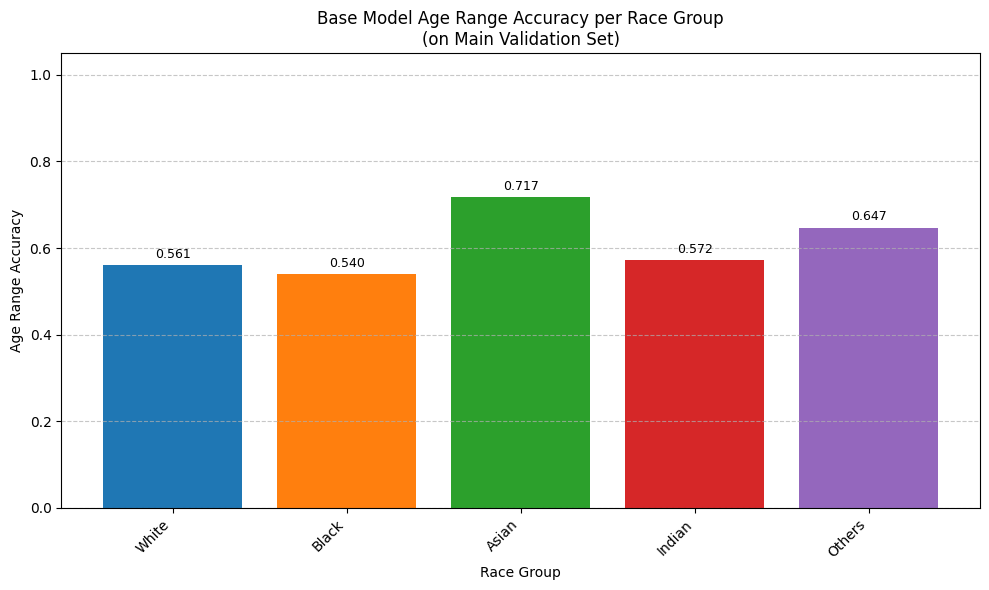

In [28]:
if 'main_val_loader' in globals() and main_val_loader is not None and len(main_val_loader.dataset) > 0:
    eval_loader_for_accuracy = main_val_loader
    eval_set_name = "Main Validation Set"
elif 'conf_set_val_loader' in globals() and conf_set_val_loader is not None and len(conf_set_val_loader.dataset) > 0:
    eval_loader_for_accuracy = conf_set_val_loader
    eval_set_name = "Z_val (Confidence Set Validation Set)"
else:
    print("ERROR: No suitable evaluation dataloader found for accuracy check.")
    eval_loader_for_accuracy = None

if model_phi and eval_loader_for_accuracy:
    model_phi.eval()

    group_corrects = {gid: 0 for gid in RACE_GROUPS.keys()}
    group_totals = {gid: 0 for gid in RACE_GROUPS.keys()}
    overall_corrects = 0
    overall_totals = 0

    with torch.no_grad():
        for inputs, target_labels, race_ids in eval_loader_for_accuracy:
            inputs = inputs.to(device)
            target_labels = target_labels.to(device)

            outputs = model_phi(inputs)
            _, preds = torch.max(outputs, 1)

            correct_predictions = (preds == target_labels)

            for i in range(len(target_labels)):
                race_id_sample = race_ids[i].item()
                if race_id_sample in RACE_GROUPS:
                    if correct_predictions[i].item():
                        group_corrects[race_id_sample] += 1
                    group_totals[race_id_sample] += 1

                if correct_predictions[i].item():
                    overall_corrects +=1
                overall_totals +=1

    # Calculate accuracies
    group_accuracies = {}
    print(f"\nBase Model ({PREDICTION_TASK_NAME}) Classification Accuracy on {eval_set_name}:")
    for group_id, group_name in RACE_GROUPS.items():
        if group_totals[group_id] > 0:
            acc = group_corrects[group_id] / group_totals[group_id]
            group_accuracies[group_id] = acc
            print(f"  Group {group_name} (ID {group_id}): {acc:.4f} ({group_corrects[group_id]}/{group_totals[group_id]})")
        else:
            group_accuracies[group_id] = float('nan')
            print(f"  Group {group_name} (ID {group_id}): No samples found in evaluation set.")

    if overall_totals > 0:
        overall_acc = overall_corrects / overall_totals
        print(f"  Overall Accuracy: {overall_acc:.4f} ({overall_corrects}/{overall_totals})")
    else:
        print("  No samples processed for overall accuracy.")


    plot_group_names = []
    plot_accuracies = []
    for group_id in sorted(RACE_GROUPS.keys()):
        if group_totals[group_id] > 0:
            plot_group_names.append(RACE_GROUPS[group_id])
            plot_accuracies.append(group_accuracies[group_id])

    if plot_group_names:
        plt.figure(figsize=(10, 6))
        bars = plt.bar(plot_group_names, plot_accuracies,
                       color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']) # Example colors

        plt.xlabel(f"{SENSITIVE_ATTR_NAME} Group")
        plt.ylabel(f"{PREDICTION_TASK_NAME} Accuracy")
        plt.title(f"Base Model {PREDICTION_TASK_NAME} Accuracy per {SENSITIVE_ATTR_NAME} Group\n(on {eval_set_name})")
        plt.xticks(rotation=45, ha="right")
        plt.ylim(0, 1.05)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.3f}',
                     ha='center', va='bottom', fontsize=9)

        plt.tight_layout()
        plt.show()
    else:
        print("No per-group accuracy data to plot (all group counts might be zero).")
else:
    print("Plotting skipped: model_phi or eval_loader_for_accuracy not available.")

In [8]:
def compute_k_star_for_group(n_g, epsilon_g, delta_g):
    k_g_star = -1
    for k_candidate in range(n_g + 1):
        cdf_at_k_candidate = binom.cdf(k_candidate, n_g, epsilon_g)
        if cdf_at_k_candidate < delta_g:
            k_g_star = k_candidate
        else:
            break
    return k_g_star

def get_calibrated_scores_for_true_labels_on_z_val(
    base_model,
    z_val_loader,
    temp_scaler,
    optimized_tau_val,
    ):
    base_model.eval()
    all_f_phi_tau_true_scores = []

    processed_indices_count = 0
    with torch.no_grad():
        for inputs, target_labels_true, group_labels_batch in z_val_loader:
            inputs_dev = inputs.to(device)
            target_labels_true_dev = target_labels_true.to(device)

            logits_phi_batch = base_model(inputs_dev)
            probs_phi_tau_batch = temp_scaler.get_scaled_probs(logits_phi_batch, current_tau_val=optimized_tau_val)

            for i in range(inputs_dev.size(0)):
                # Get f_phi_tau for the true target_label
                true_label_prob_for_sample = probs_phi_tau_batch[i, target_labels_true_dev[i]].item()
                all_f_phi_tau_true_scores.append(true_label_prob_for_sample)

    return np.array(all_f_phi_tau_true_scores)

per_group_candidate_s_thresholds = {}
per_group_k_g = {}
per_group_n_g = {}

for group_id, group_name in RACE_GROUPS.items():
    # Create a Z_val_g by filtering conf_set_val_dataset
    group_g_indices = [i for i, r_label in enumerate(conf_set_val_dataset.race_labels) if r_label == group_id]

    n_g = len(group_g_indices)
    per_group_n_g[group_id] = n_g
    print(f"  Processing Group {group_name} (ID {group_id}): n_g = {n_g}")

    k_g = compute_k_star_for_group(n_g, EPSILON_PAC, DELTA_PAC)
    per_group_k_g[group_id] = k_g
    print(f"    k_g (allowable misses): {k_g}")

    z_val_g_files = [conf_set_val_dataset.image_files[i] for i in group_g_indices]
    z_val_g_targets = [conf_set_val_dataset.age_class_labels[i] for i in group_g_indices]
    z_val_g_races = [conf_set_val_dataset.race_labels[i] for i in group_g_indices]

    temp_z_val_g_dataset = UTKFaceAgeRaceDataset(transform=common_transform,
                                                    file_list=z_val_g_files,
                                                    age_class_labels=z_val_g_targets,
                                                    race_labels=z_val_g_races)
    temp_z_val_g_loader = DataLoader(temp_z_val_g_dataset, batch_size=BATCH_SIZE, shuffle=False)

    scores_true_label_for_group_g = get_calibrated_scores_for_true_labels_on_z_val(
        model_phi, temp_z_val_g_loader, temp_scaler_obj, OPTIMIZED_TAU
    )

    sorted_scores_g = np.sort(scores_true_label_for_group_g)

    final_idx_for_s_g_threshold = k_g
    while final_idx_for_s_g_threshold > 0 and \
          n_g > 1 and \
          np.isclose(sorted_scores_g[final_idx_for_s_g_threshold], sorted_scores_g[final_idx_for_s_g_threshold - 1]):
        final_idx_for_s_g_threshold -= 1

    candidate_s_g = sorted_scores_g[final_idx_for_s_g_threshold]
    per_group_candidate_s_thresholds[group_id] = candidate_s_g
    print(f"    Sorted scores (sample): {sorted_scores_g[:min(3,n_g)]} ... {sorted_scores_g[max(0,n_g-3):]}")
    print(f"    Candidate s^g_({k_g}+1) (score threshold for group {group_name}): {candidate_s_g:.6f} (from index {final_idx_for_s_g_threshold})")


S_SHARED_THRESHOLD_ALG1 = min(s for s in per_group_candidate_s_thresholds.values() if s is not None and not np.isinf(s))
T_SHARED_ALG1 = -math.log(S_SHARED_THRESHOLD_ALG1)

print(f"\nAlgorithm I Results:")
print(f"  Per-group candidate s_thresholds: {per_group_candidate_s_thresholds}")
print(f"  Shared Score Threshold (s_shared_threshold_alg1): {S_SHARED_THRESHOLD_ALG1:.6f}")
print(f"  Shared Log-Threshold (T_shared_alg1): {T_SHARED_ALG1:.6f}")


# Will use it later for Alg II
T_g_base_values_alg2 = {}
S_g_baseline  = {}
for group_id, s_g_candidate in per_group_candidate_s_thresholds.items():
    S_g_baseline[group_id] = s_g_candidate
    T_g_base_values_alg2[group_id] = -math.log(s_g_candidate)
print(f"Base T_g values for Algorithm II (from individual PAC): {T_g_base_values_alg2}")

  Processing Group White (ID 0): n_g = 2016
    k_g (allowable misses): 179
    Sorted scores (sample): [0.0012671  0.00307885 0.00314282] ... [0.99950182 0.99952948 0.99963641]
    Candidate s^g_(179+1) (score threshold for group White): 0.101930 (from index 179)
  Processing Group Black (ID 1): n_g = 905
    k_g (allowable misses): 75
    Sorted scores (sample): [0.00466382 0.00834501 0.01141095] ... [0.9913401  0.99386889 0.99670643]
    Candidate s^g_(75+1) (score threshold for group Black): 0.100513 (from index 75)
  Processing Group Asian (ID 2): n_g = 687
    k_g (allowable misses): 55
    Sorted scores (sample): [0.00158382 0.00290306 0.00327721] ... [0.99967325 0.99981874 0.99986708]
    Candidate s^g_(55+1) (score threshold for group Asian): 0.147520 (from index 55)
  Processing Group Indian (ID 3): n_g = 795
    k_g (allowable misses): 65
    Sorted scores (sample): [0.00131409 0.0051635  0.00568845] ... [0.99921191 0.99921417 0.99933761]
    Candidate s^g_(65+1) (score thre

In [12]:
# Baseline
def construct_confidence_set_for_sample(
    single_input_logits_phi,
    temp_scaler,
    tau_val,
    score_threshold,
    num_pred_classes=10
    ):
    temp_scaler.model_phi.eval()
    with torch.no_grad():
        calibrated_probs_all_classes = temp_scaler.get_scaled_probs(
            single_input_logits_phi.to(device), current_tau_val=tau_val
        )

        predicted_confidence_set = []
        for class_idx in range(num_pred_classes):
            if calibrated_probs_all_classes[0, class_idx].item() >= score_threshold:
                predicted_confidence_set.append(class_idx)
        return predicted_confidence_set, calibrated_probs_all_classes.squeeze().cpu().numpy()

def evaluate_confidence_sets(
    eval_model_phi,
    eval_loader,
    eval_temp_scaler,
    eval_tau,
    threshold_map,
    num_pred_classes=10,
    algorithm_name="Algorithm"
    ):
    eval_model_phi.eval()
    results = {}
    # Initialize accumulators for each group and overall
    for g_id in list(RACE_GROUPS.keys()) + ['overall']:
        results[g_id] = {'covered': 0, 'total_samples': 0, 'total_set_size': 0, 'avg_set_size': 0, 'coverage': 0, 'T_g_used_avg_log_score_pred': []}


    with torch.no_grad():
        for inputs, target_labels_true, race_labels_group in eval_loader:
            inputs_dev = inputs.to(device)
            logits_phi_batch = eval_model_phi(inputs_dev)

            for i in range(inputs_dev.size(0)):
                current_true_target_label = target_labels_true[i].item()
                current_race_group_id = race_labels_group[i].item()
                current_single_logits = logits_phi_batch[i].unsqueeze(0)

                # Determine threshold: either shared or per-group
                current_score_threshold = threshold_map if isinstance(threshold_map, float) else threshold_map.get(current_race_group_id, -1.0)
                if current_score_threshold == -1.0:
                    print(f"Warning: No threshold found for group {current_race_group_id}. Skipping sample."); continue

                conf_set, calibrated_probs = construct_confidence_set_for_sample(
                    current_single_logits, eval_temp_scaler, eval_tau, current_score_threshold, num_pred_classes
                )

                if current_true_target_label in conf_set:
                    results[current_race_group_id]['covered'] += 1
                results[current_race_group_id]['total_samples'] += 1
                results[current_race_group_id]['total_set_size'] += len(conf_set)
                results[current_race_group_id]['T_g_used_avg_log_score_pred'].append(-math.log(current_score_threshold) if current_score_threshold > 0 else float('inf'))


                # Update overall stats
                if current_true_target_label in conf_set:
                    results['overall']['covered'] += 1
                results['overall']['total_samples'] += 1
                results['overall']['total_set_size'] += len(conf_set)
                results['overall']['T_g_used_avg_log_score_pred'].append(-math.log(current_score_threshold) if current_score_threshold > 0 else float('inf'))


    # Calculate averages and coverage
    summary_data = []
    for g_id, data in results.items():
        group_name_str = RACE_GROUPS.get(g_id, "Overall") if g_id != 'overall' else "Overall"
        if data['total_samples'] > 0:
            data['avg_set_size'] = data['total_set_size'] / data['total_samples']
            data['coverage'] = data['covered'] / data['total_samples']
            avg_T_g_used = np.mean([t for t in data['T_g_used_avg_log_score_pred'] if not np.isinf(t) and not np.isnan(t)]) if data['T_g_used_avg_log_score_pred'] else float('nan')
        else:
            data['avg_set_size'] = 0
            data['coverage'] = 0
            avg_T_g_used = float('nan')

        summary_data.append({
            "Algorithm": algorithm_name,
            "Group": group_name_str,
            "GroupID": g_id,
            "Samples (n_g)": data['total_samples'],
            "Coverage": f"{data['coverage']:.3f}",
            "AvgSetSize": f"{data['avg_set_size']:.3f}",
            "Avg_T_used": f"{avg_T_g_used:.3f}"
        })
        # Add k_g if available (for Algorithm I context)
        if g_id in per_group_k_g:
             summary_data[-1]["k_g (PAC)"] = per_group_k_g[g_id]


    summary_df = pd.DataFrame(summary_data)
    print(f"\n--- Evaluation Summary for {algorithm_name} ---")
    print(summary_df.to_string())
    return results, summary_df


print(f"\n--- Evaluating Algorithm I using Shared Threshold on Z_val ---")
results_alg1, summary_df_alg1 = evaluate_confidence_sets(
    model_phi, conf_set_val_loader, temp_scaler_obj, OPTIMIZED_TAU,
    S_g_baseline,
    num_pred_classes=10,
    algorithm_name="Baseline (diff T)"
)


--- Evaluating Algorithm I using Shared Threshold on Z_val ---

--- Evaluation Summary for Baseline (diff T) ---
           Algorithm                                      Group  GroupID  Samples (n_g) Coverage AvgSetSize Avg_T_used  k_g (PAC)
0  Baseline (diff T)                                      White        0           2016    0.911      2.533      2.283      179.0
1  Baseline (diff T)                                      Black        1            905    0.917      2.476      2.297       75.0
2  Baseline (diff T)                                      Asian        2            687    0.920      1.697      1.914       55.0
3  Baseline (diff T)                                     Indian        3            795    0.918      2.210      2.101       65.0
4  Baseline (diff T)  Others (Hispanic, Latino, Middle Eastern)        4            338    0.929      2.027      2.218       24.0
5  Baseline (diff T)                                    Overall  overall           4741    0.916      2.31

In [13]:
#Shared
def get_all_true_label_scores_from_z_val(
    base_model,
    full_z_val_loader,
    temp_scaler,
    optimized_tau_val
    ):
    base_model.eval()
    all_true_scores = []
    if full_z_val_loader is None or len(full_z_val_loader.dataset) == 0:
        print("Warning: full_z_val_loader is empty.")
        return np.array([])
    with torch.no_grad():
        for inputs, target_labels_true, _ in full_z_val_loader:
            inputs_dev, target_labels_true_dev = inputs.to(device), target_labels_true.to(device)
            logits_phi_batch = base_model(inputs_dev)
            probs_phi_tau_batch = temp_scaler.get_scaled_probs(logits_phi_batch, current_tau_val=optimized_tau_val)
            true_label_probs_batch = probs_phi_tau_batch.gather(1, target_labels_true_dev.unsqueeze(1)).squeeze().cpu().numpy()
            all_true_scores.extend(true_label_probs_batch)
    return np.array(all_true_scores)

S_GLOBAL_THRESHOLD_BASELINE = -1.0

if 'conf_set_val_dataset' in globals() and conf_set_val_dataset and len(conf_set_val_dataset) > 0 and \
   'conf_set_val_loader' in globals() and conf_set_val_loader:

    n_total_z_val = len(conf_set_val_dataset)
    print(f"Total samples in Z_val for global threshold: {n_total_z_val}")

    k_star_total = compute_k_star_for_group(n_total_z_val, EPSILON_PAC, DELTA_PAC)
    print(f"Global k_star_total (allowed misses on full Z_val): {k_star_total}")

    if k_star_total != -1:
        all_z_val_true_scores = get_all_true_label_scores_from_z_val(
            model_phi, conf_set_val_loader, temp_scaler_obj, OPTIMIZED_TAU
        )

        if all_z_val_true_scores.size > 0:
            sorted_total_scores = np.sort(all_z_val_true_scores)

            idx_for_global_threshold = k_star_total
            if idx_for_global_threshold >= n_total_z_val: idx_for_global_threshold = n_total_z_val - 1
            if idx_for_global_threshold < 0 : idx_for_global_threshold = 0

            final_idx_global_threshold = idx_for_global_threshold
            if n_total_z_val > 1:
                while final_idx_global_threshold > 0 and \
                      np.isclose(sorted_total_scores[final_idx_global_threshold], sorted_total_scores[final_idx_global_threshold - 1]):
                    final_idx_global_threshold -= 1

            S_GLOBAL_THRESHOLD_BASELINE = sorted_total_scores[final_idx_global_threshold]
            T_GLOBAL_BASELINE = -math.log(S_GLOBAL_THRESHOLD_BASELINE) if S_GLOBAL_THRESHOLD_BASELINE > 0 else float('inf')

            print(f"Global Score Threshold (S_GLOBAL_THRESHOLD_BASELINE): {S_GLOBAL_THRESHOLD_BASELINE:.6f}")
            print(f"Global Log-Threshold (T_GLOBAL_BASELINE): {T_GLOBAL_BASELINE:.4f}")

            empirical_misses_total = np.sum(all_z_val_true_scores < S_GLOBAL_THRESHOLD_BASELINE)
            print(f"Empirical misses on full Z_val using global threshold: {empirical_misses_total} (should be <= {k_star_total})")

        else:
            print("ERROR: Could not retrieve scores from Z_val for global threshold.")
    else:
        print(f"ERROR: Global k_star_total is -1. Cannot derive global threshold. Check EPSILON_PAC/DELTA_PAC for n_total_z_val={n_total_z_val}.")
else:
    print("ERROR: conf_set_val_dataset or conf_set_val_loader is not available for baseline experiment.")


if S_GLOBAL_THRESHOLD_BASELINE != -1.0 and 'conf_set_val_loader' in globals() and conf_set_val_loader:
    print(f"\n--- Evaluating Per-Group Performance using S_GLOBAL_THRESHOLD_BASELINE on Z_val ---")

    num_prediction_classes_for_eval = 10


    results_baseline, summary_df_baseline = evaluate_confidence_sets(
        model_phi,
        conf_set_val_loader,
        temp_scaler_obj,
        OPTIMIZED_TAU,
        float(S_GLOBAL_THRESHOLD_BASELINE),
        num_pred_classes=num_prediction_classes_for_eval,
        algorithm_name="Baseline (Global Threshold on Z_val)"
    )

    if summary_df_baseline is not None:
        print("\nBaseline Experiment Results (Per Group):")
        summary_df_baseline['Effective_Epsilon'] = 1.0 - pd.to_numeric(summary_df_baseline['Coverage'], errors='coerce')


        columns_to_display = ["Algorithm", "Group", "Samples (n_g)", "Coverage", "Effective_Epsilon", "AvgSetSize", "Avg_T_used"]
        display_cols_present = [col for col in columns_to_display if col in summary_df_baseline.columns]

        print(summary_df_baseline[display_cols_present].to_string(float_format="%.3f"))

else:
    print("Skipping per-group evaluation for baseline as global threshold was not computed or Z_val loader is missing.")

Total samples in Z_val for global threshold: 4741
Global k_star_total (allowed misses on full Z_val): 439
Global Score Threshold (S_GLOBAL_THRESHOLD_BASELINE): 0.117102
Global Log-Threshold (T_GLOBAL_BASELINE): 2.1447
Empirical misses on full Z_val using global threshold: 439 (should be <= 439)

--- Evaluating Per-Group Performance using S_GLOBAL_THRESHOLD_BASELINE on Z_val ---

--- Evaluation Summary for Baseline (Global Threshold on Z_val) ---
                              Algorithm                                      Group  GroupID  Samples (n_g) Coverage AvgSetSize Avg_T_used  k_g (PAC)
0  Baseline (Global Threshold on Z_val)                                      White        0           2016    0.895      2.409      2.145      179.0
1  Baseline (Global Threshold on Z_val)                                      Black        1            905    0.893      2.339      2.145       75.0
2  Baseline (Global Threshold on Z_val)                                      Asian        2            

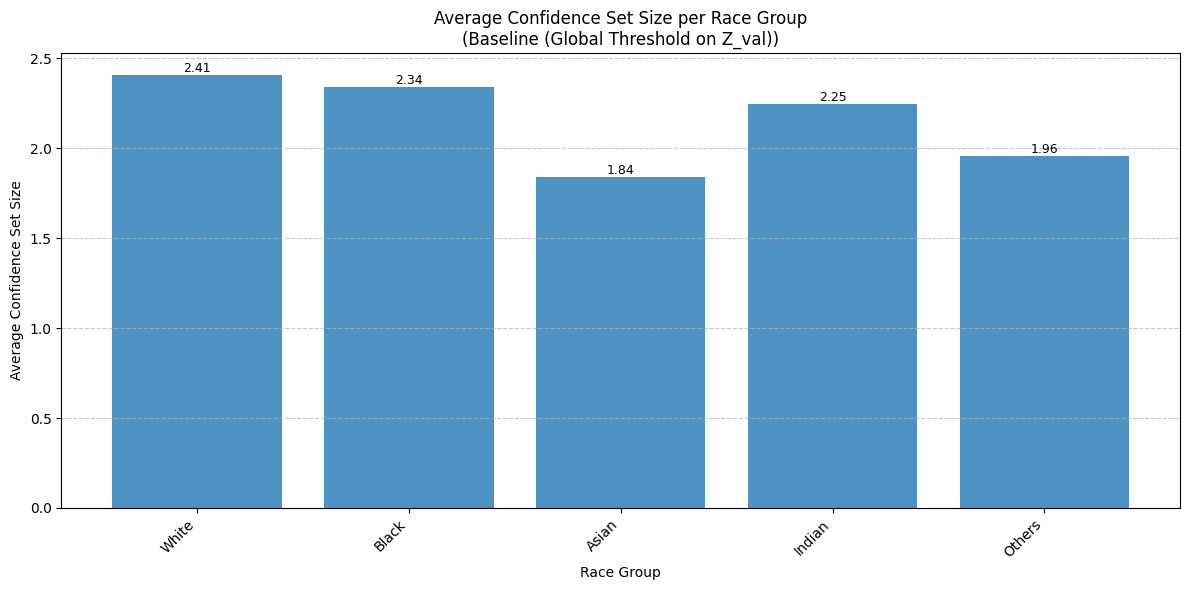

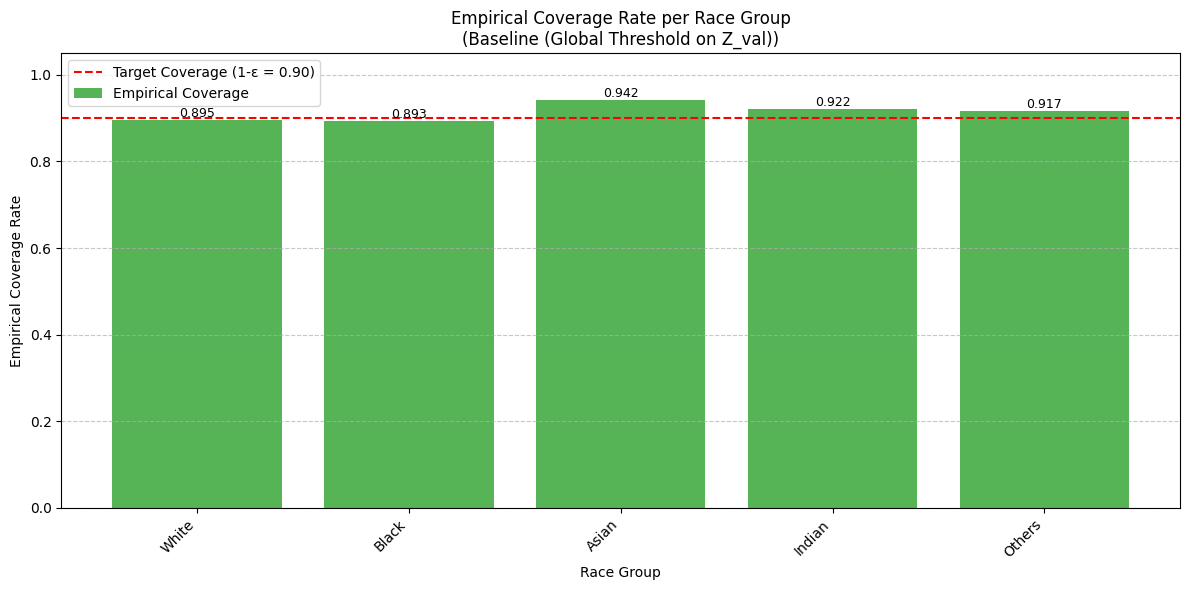

In [29]:
if 'results_baseline' in globals() and results_baseline is not None:

    if 'summary_df_baseline' in globals() and summary_df_baseline is not None and not summary_df_baseline.empty:
        algorithm_name_for_titles = summary_df_baseline["Algorithm"].iloc[0]
    else:
        algorithm_name_for_titles = "Algorithm I (Shared T)"

    group_names_plot = []
    avg_set_sizes_plot = []
    coverages_plot = []

    for group_id in sorted(RACE_GROUPS.keys()):
        group_name = RACE_GROUPS[group_id]
        if group_id in results_baseline and results_baseline[group_id]['total_samples'] > 0:
            group_names_plot.append(group_name)
            avg_set_sizes_plot.append(results_baseline[group_id]['avg_set_size'])
            coverages_plot.append(results_baseline[group_id]['coverage'])
        elif group_id in results_baseline:
            group_names_plot.append(group_name)
            avg_set_sizes_plot.append(0)
            coverages_plot.append(float('nan'))

    if not group_names_plot:
        print(f"No valid per-group data to plot for {algorithm_name_for_titles}.")
    else:
        plt.figure(figsize=(12, 6))
        bars_set_size = plt.bar(group_names_plot, avg_set_sizes_plot,
                                color='#1f77b4', alpha=0.8, label="Avg. Set Size")

        plt.xlabel(f"{SENSITIVE_ATTR_NAME} Group")
        plt.ylabel("Average Confidence Set Size")
        plt.title(f"Average Confidence Set Size per {SENSITIVE_ATTR_NAME} Group\n({algorithm_name_for_titles})")
        plt.xticks(rotation=45, ha="right")
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        if all(s >= 0 for s in avg_set_sizes_plot):
            plt.ylim(bottom=0)

        for bar in bars_set_size:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}',
                     ha='center', va='bottom', fontsize=9, color='black')

        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(12, 6))


        plot_names_coverage = [name for i, name in enumerate(group_names_plot) if not np.isnan(coverages_plot[i])]
        plot_values_coverage = [val for val in coverages_plot if not np.isnan(val)]

        if plot_names_coverage:
            bars_coverage = plt.bar(plot_names_coverage, plot_values_coverage,
                                    color='#2ca02c', alpha=0.8, label="Empirical Coverage")

            plt.xlabel(f"{SENSITIVE_ATTR_NAME} Group")
            plt.ylabel("Empirical Coverage Rate")
            plt.title(f"Empirical Coverage Rate per {SENSITIVE_ATTR_NAME} Group\n({algorithm_name_for_titles})")
            plt.xticks(rotation=45, ha="right")
            plt.ylim(0, 1.05)
            plt.grid(axis='y', linestyle='--', alpha=0.7)

            if 'EPSILON_PAC' in globals() and EPSILON_PAC is not None:
                target_coverage = 1.0 - EPSILON_PAC
                plt.axhline(y=target_coverage, color='r', linestyle='--',
                            label=f'Target Coverage (1-ε = {target_coverage:.2f})')
                plt.legend()

            for bar in bars_coverage:
                yval = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.3f}',
                         ha='center', va='bottom', fontsize=9, color='black')

            plt.tight_layout()
            plt.show()
        else:
            print(f"No valid coverage data to plot for {algorithm_name_for_titles} (all groups might have 0 samples).")

else:
    print("Plotting skipped: 'results_baseline' dictionary (or your chosen results dictionary) not found or is None.")
    print("Please ensure you have run an evaluation and stored its output correctly.")

In [16]:
def construct_confidence_set_for_sample(
    single_input_logits_phi,
    temp_scaler,
    tau_val,
    score_threshold,
    num_pred_classes=10
    ):
    temp_scaler.model_phi.eval()
    with torch.no_grad():
        calibrated_probs_all_classes = temp_scaler.get_scaled_probs(
            single_input_logits_phi.to(device), current_tau_val=tau_val
        )

        predicted_confidence_set = []
        for class_idx in range(num_pred_classes):
            if calibrated_probs_all_classes[0, class_idx].item() >= score_threshold:
                predicted_confidence_set.append(class_idx)
        return predicted_confidence_set, calibrated_probs_all_classes.squeeze().cpu().numpy()

def evaluate_confidence_sets(
    eval_model_phi,
    eval_loader,
    eval_temp_scaler,
    eval_tau,
    threshold_map,
    num_pred_classes=10,
    algorithm_name="Algorithm"
    ):
    eval_model_phi.eval()
    results = {}
    # Initialize accumulators for each group and overall
    for g_id in list(RACE_GROUPS.keys()) + ['overall']:
        results[g_id] = {'covered': 0, 'total_samples': 0, 'total_set_size': 0, 'avg_set_size': 0, 'coverage': 0, 'T_g_used_avg_log_score_pred': []}


    with torch.no_grad():
        for inputs, target_labels_true, race_labels_group in eval_loader:
            inputs_dev = inputs.to(device)
            logits_phi_batch = eval_model_phi(inputs_dev)

            for i in range(inputs_dev.size(0)):
                current_true_target_label = target_labels_true[i].item()
                current_race_group_id = race_labels_group[i].item()
                current_single_logits = logits_phi_batch[i].unsqueeze(0)

                # Determine threshold: either shared or per-group
                current_score_threshold = threshold_map if isinstance(threshold_map, float) else threshold_map.get(current_race_group_id, -1.0)
                if current_score_threshold == -1.0:
                    print(f"Warning: No threshold found for group {current_race_group_id}. Skipping sample."); continue

                conf_set, calibrated_probs = construct_confidence_set_for_sample(
                    current_single_logits, eval_temp_scaler, eval_tau, current_score_threshold, num_pred_classes
                )

                if current_true_target_label in conf_set:
                    results[current_race_group_id]['covered'] += 1
                results[current_race_group_id]['total_samples'] += 1
                results[current_race_group_id]['total_set_size'] += len(conf_set)
                results[current_race_group_id]['T_g_used_avg_log_score_pred'].append(-math.log(current_score_threshold) if current_score_threshold > 0 else float('inf'))


                # Update overall stats
                if current_true_target_label in conf_set:
                    results['overall']['covered'] += 1
                results['overall']['total_samples'] += 1
                results['overall']['total_set_size'] += len(conf_set)
                results['overall']['T_g_used_avg_log_score_pred'].append(-math.log(current_score_threshold) if current_score_threshold > 0 else float('inf'))


    # Calculate averages and coverage
    summary_data = []
    for g_id, data in results.items():
        group_name_str = RACE_GROUPS.get(g_id, "Overall") if g_id != 'overall' else "Overall"
        if data['total_samples'] > 0:
            data['avg_set_size'] = data['total_set_size'] / data['total_samples']
            data['coverage'] = data['covered'] / data['total_samples']
            avg_T_g_used = np.mean([t for t in data['T_g_used_avg_log_score_pred'] if not np.isinf(t) and not np.isnan(t)]) if data['T_g_used_avg_log_score_pred'] else float('nan')
        else:
            data['avg_set_size'] = 0
            data['coverage'] = 0
            avg_T_g_used = float('nan')

        summary_data.append({
            "Algorithm": algorithm_name,
            "Group": group_name_str,
            "GroupID": g_id,
            "Samples (n_g)": data['total_samples'],
            "Coverage": f"{data['coverage']:.3f}",
            "AvgSetSize": f"{data['avg_set_size']:.3f}",
            "Avg_T_used": f"{avg_T_g_used:.3f}"
        })
        # Add k_g if available (for Algorithm I context)
        if g_id in per_group_k_g:
             summary_data[-1]["k_g (PAC)"] = per_group_k_g[g_id]


    summary_df = pd.DataFrame(summary_data)
    print(f"\n--- Evaluation Summary for {algorithm_name} ---")
    print(summary_df.to_string())
    return results, summary_df


print(f"\n--- Evaluating Algorithm I using Shared Threshold on Z_val ---")
results_alg1, summary_df_alg1 = evaluate_confidence_sets(
    model_phi, conf_set_val_loader, temp_scaler_obj, OPTIMIZED_TAU,
    S_SHARED_THRESHOLD_ALG1,
    num_pred_classes=10,
    algorithm_name="Algorithm I (Shared T)"
)


--- Evaluating Algorithm I using Shared Threshold on Z_val ---

--- Evaluation Summary for Algorithm I (Shared T) ---
                Algorithm                                      Group  GroupID  Samples (n_g) Coverage AvgSetSize Avg_T_used  k_g (PAC)
0  Algorithm I (Shared T)                                      White        0           2016    0.913      2.544      2.297      179.0
1  Algorithm I (Shared T)                                      Black        1            905    0.917      2.476      2.297       75.0
2  Algorithm I (Shared T)                                      Asian        2            687    0.948      1.936      2.297       55.0
3  Algorithm I (Shared T)                                     Indian        3            795    0.936      2.389      2.297       65.0
4  Algorithm I (Shared T)  Others (Hispanic, Latino, Middle Eastern)        4            338    0.932      2.062      2.297       24.0
5  Algorithm I (Shared T)                                    Overall  o

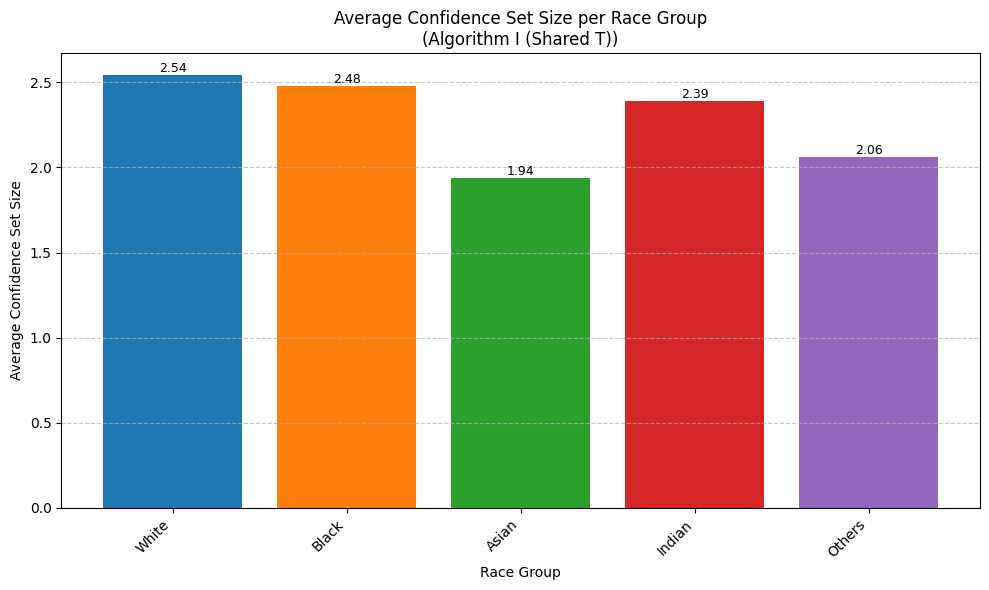

In [30]:
if 'results_alg1' in globals() and results_alg1 is not None:
    group_names_for_plot = []
    avg_set_sizes_for_plot = []

    if 'summary_df_alg1' in globals() and summary_df_alg1 is not None and not summary_df_alg1.empty:
        algorithm_name_for_title = summary_df_alg1["Algorithm"].iloc[0]
    else:
        algorithm_name_for_title = "Algorithm I (Shared T)"

    for group_id in sorted(RACE_GROUPS.keys()):
        group_name = RACE_GROUPS[group_id]
        if group_id in results_alg1 and results_alg1[group_id]['total_samples'] > 0:
            group_names_for_plot.append(group_name)
            avg_set_sizes_for_plot.append(results_alg1[group_id]['avg_set_size'])
        elif group_id in results_alg1:
            group_names_for_plot.append(group_name)
            avg_set_sizes_for_plot.append(0)


    if group_names_for_plot:
        plt.figure(figsize=(10, 6))

        # Create bars
        bars = plt.bar(group_names_for_plot, avg_set_sizes_for_plot,
                       color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']) # Example colors

        plt.xlabel(f"{SENSITIVE_ATTR_NAME} Group")
        plt.ylabel("Average Confidence Set Size")
        plt.title(f"Average Confidence Set Size per {SENSITIVE_ATTR_NAME} Group\n({algorithm_name_for_title})")
        plt.xticks(rotation=45, ha="right") # Rotate x-axis labels for better readability
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Ensure y-axis starts at 0 if all values are non-negative
        if all(s >= 0 for s in avg_set_sizes_for_plot):
            plt.ylim(bottom=0)

        # Add text labels on top of each bar for clarity
        for bar in bars:
            yval = bar.get_height()
            # Adjust text position slightly above the bar
            plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}',
                     ha='center', va='bottom', fontsize=9, color='black')

        plt.tight_layout() # Adjust layout to prevent labels from overlapping
        plt.show()
    else:
        print(f"No valid per-group average set size data to plot for {algorithm_name_for_title}.")
        print("Please ensure 'results_alg1' contains data for the defined RACE_GROUPS.")

else:
    print("Plotting skipped: 'results_alg1' dictionary not found or is None.")
    print("Please ensure you have run the evaluation for Algorithm I and stored its output in 'results_alg1'.")

#Algorithm 2


---
Processing Algorithm II with lambda_norm = 0.00
---
  Calculated T_avg_base (for adjustment): 2.1973
  Group White (ID 0): T_base=2.2835 -> T_adjusted=2.2835 (s_adjusted=0.101930)
  Group Black (ID 1): T_base=2.2975 -> T_adjusted=2.2975 (s_adjusted=0.100513)
  Group Asian (ID 2): T_base=1.9138 -> T_adjusted=1.9138 (s_adjusted=0.147520)
  Group Indian (ID 3): T_base=2.1009 -> T_adjusted=2.1009 (s_adjusted=0.122350)
  Group Others (Hispanic, Latino, Middle Eastern) (ID 4): T_base=2.2185 -> T_adjusted=2.2185 (s_adjusted=0.108777)

--- Evaluation Summary for Algorithm II (lambda_norm=0.00) ---
                         Algorithm                                      Group  GroupID  Samples (n_g) Coverage AvgSetSize Avg_T_used  k_g (PAC)
0  Algorithm II (lambda_norm=0.00)                                      White        0           2016    0.911      2.533      2.283      179.0
1  Algorithm II (lambda_norm=0.00)                                      Black        1            905    0.916

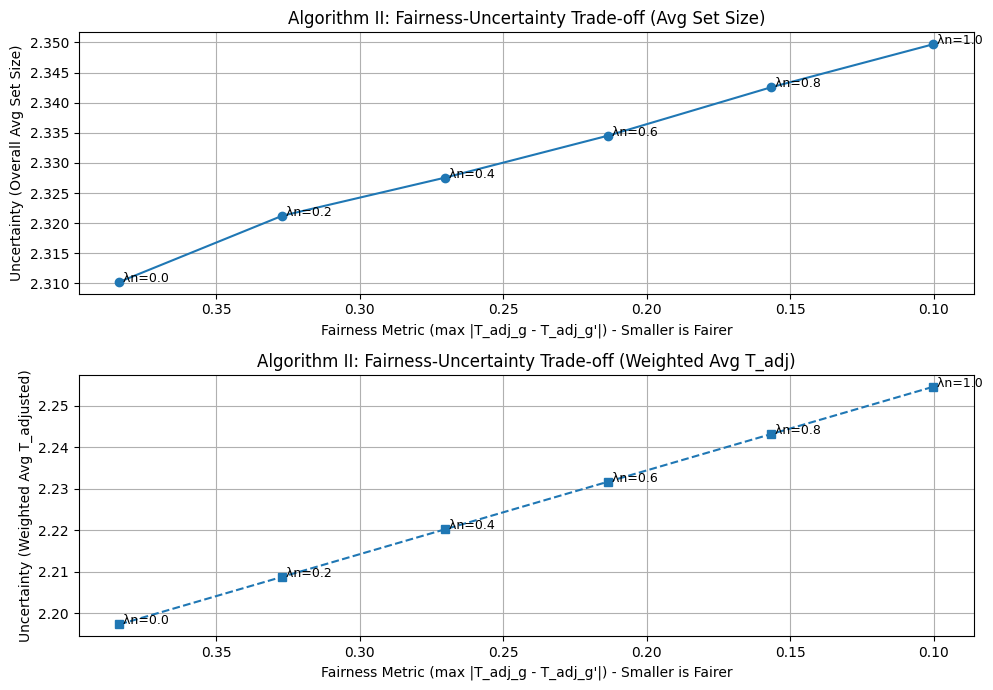

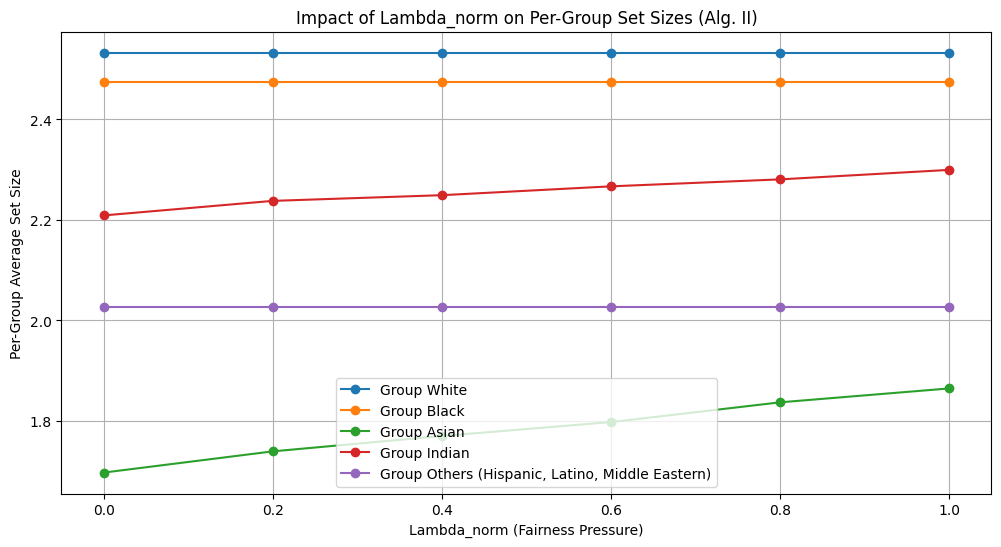


--- Full Script Execution Finished ---


In [18]:
LAMBDA_NORM_VALUES = np.linspace(0, 1, 6)
trade_off_points = []

group_weights_w_g = {}
total_samples_z_val = sum(per_group_n_g.get(gid,0) for gid in RACE_GROUPS.keys())
if total_samples_z_val > 0 :
    for g_id in RACE_GROUPS.keys():
        group_weights_w_g[g_id] = per_group_n_g.get(g_id,0) / total_samples_z_val
else:
    for g_id in RACE_GROUPS.keys(): group_weights_w_g[g_id] = 1.0 / NUM_RACE_GROUPS


for lambda_norm in LAMBDA_NORM_VALUES:
    print(f"\n---\nProcessing Algorithm II with lambda_norm = {lambda_norm:.2f}\n---")

    current_T_g_adjusted = {}
    current_s_g_thresholds_adjusted = {}

    valid_T_g_bases = [T_g_base_values_alg2[gid] for gid in RACE_GROUPS.keys() if gid in T_g_base_values_alg2 and not np.isnan(T_g_base_values_alg2[gid]) and not np.isinf(T_g_base_values_alg2[gid])]
    if not valid_T_g_bases:
        print("Warning: No valid T_g_base values to compute T_avg_base. Skipping this lambda_norm.")
        continue

    weighted_sum_T = 0
    sum_weights_for_avg = 0
    for gid_avg, t_base_avg in T_g_base_values_alg2.items():
        if gid_avg in RACE_GROUPS.keys() and not np.isnan(t_base_avg) and not np.isinf(t_base_avg):
            weighted_sum_T += group_weights_w_g.get(gid_avg,0) * t_base_avg
            sum_weights_for_avg += group_weights_w_g.get(gid_avg,0)

    T_avg_base_for_adjust = weighted_sum_T / sum_weights_for_avg if sum_weights_for_avg > 0 else np.mean(valid_T_g_bases)
    print(f"  Calculated T_avg_base (for adjustment): {T_avg_base_for_adjust:.4f}")


    for group_id, T_base_g in T_g_base_values_alg2.items():
        if group_id not in RACE_GROUPS.keys(): continue

        if np.isnan(T_base_g) or np.isinf(T_base_g):
            print(f"  Group {RACE_GROUPS.get(group_id, group_id)}: T_base_g is problematic ({T_base_g}). Using inf for T_g_adjusted (implies s_g_adj=0).")
            T_adj_g = float('inf')
            s_adj_g = 0.0
        else:
            adjustment_term = lambda_norm * (T_avg_base_for_adjust - T_base_g)
            T_adj_g = max(T_base_g, T_base_g + adjustment_term)

            if T_adj_g > 1e6:
                s_adj_g = 0.0
            elif T_adj_g < -1e6:
                s_adj_g = 1.0
            else:
                s_adj_g = math.exp(-T_adj_g) if not np.isinf(T_adj_g) else 0.0

        current_T_g_adjusted[group_id] = T_adj_g
        current_s_g_thresholds_adjusted[group_id] = s_adj_g
        print(f"  Group {RACE_GROUPS.get(group_id,group_id)} (ID {group_id}): T_base={T_base_g:.4f} -> T_adjusted={T_adj_g:.4f} (s_adjusted={s_adj_g:.6f})")

    # Evaluate with these per-group adjusted thresholds current_s_g_thresholds_adjusted
    if conf_set_val_loader:
        results_alg2_current_lambda, summary_df_alg2_lambda = evaluate_confidence_sets(
            model_phi, conf_set_val_loader, temp_scaler_obj, OPTIMIZED_TAU,
            current_s_g_thresholds_adjusted,
            num_pred_classes=10,
            algorithm_name=f"Algorithm II (lambda_norm={lambda_norm:.2f})"
        )

        if results_alg2_current_lambda:
            # Calculate Fairness Metric F_adjusted = max |T_g_adj - T_g'_adj|
            valid_T_g_adj_values = [t for t in current_T_g_adjusted.values() if t is not None and not np.isnan(t) and not np.isinf(t)]
            if len(valid_T_g_adj_values) >= 2:
                fairness_metric_F = max(valid_T_g_adj_values) - min(valid_T_g_adj_values)
            elif len(valid_T_g_adj_values) == 1:
                 fairness_metric_F = 0.0
            else:
                fairness_metric_F = float('nan')

            overall_avg_set_size = results_alg2_current_lambda['overall']['avg_set_size']

            uncertainty_metric_U_T_sum = 0
            sum_weights_for_U = 0
            for gid_U, t_adj_U in current_T_g_adjusted.items():
                if gid_U in RACE_GROUPS.keys() and not np.isnan(t_adj_U) and not np.isinf(t_adj_U):
                    uncertainty_metric_U_T_sum += group_weights_w_g.get(gid_U,0) * t_adj_U
                    sum_weights_for_U += group_weights_w_g.get(gid_U,0)

            if sum_weights_for_U > 0:
                uncertainty_metric_U_T_weighted_avg = uncertainty_metric_U_T_sum / sum_weights_for_U
            else:
                uncertainty_metric_U_T_weighted_avg = float('nan')


            print(f"    For lambda_norm={lambda_norm:.2f}: F (max|T_adj-T'_adj|) = {fairness_metric_F:.4f}, U (OverallAvgSetSize) = {overall_avg_set_size:.4f}, U (WeightedAvg_T_adj) = {uncertainty_metric_U_T_weighted_avg:.4f}")
            trade_off_points.append({
                "lambda_norm": lambda_norm,
                "F_max_T_disparity": fairness_metric_F,
                "U_overall_avg_set_size": overall_avg_set_size,
                "U_weighted_avg_T_adj": uncertainty_metric_U_T_weighted_avg,
                "per_group_T_adj": current_T_g_adjusted.copy(),
                "per_group_avg_set_size": {gid: res_data['avg_set_size'] for gid, res_data in results_alg2_current_lambda.items() if gid != 'overall'}
            })
    else:
        print("Z_val loader not available, cannot evaluate Algorithm II for this lambda_norm.")


if trade_off_points:
    df_trade_off = pd.DataFrame(trade_off_points)
    print("\n--- Trade-off Data (Algorithm II) ---")
    print(df_trade_off[['lambda_norm', 'F_max_T_disparity', 'U_overall_avg_set_size', 'U_weighted_avg_T_adj']].to_string())

    plt.figure(figsize=(10, 7))

    # Plot 1: Max T Disparity vs Overall Avg Set Size
    plt.subplot(2,1,1)
    plt.plot(df_trade_off['F_max_T_disparity'], df_trade_off['U_overall_avg_set_size'], marker='o', linestyle='-')
    for i, point in df_trade_off.iterrows():
        plt.text(point['F_max_T_disparity'], point['U_overall_avg_set_size'], f" λn={point['lambda_norm']:.1f}", fontsize=9)
    plt.xlabel(f"Fairness Metric (max |T_adj_g - T_adj_g'|) - Smaller is Fairer")
    plt.ylabel("Uncertainty (Overall Avg Set Size)")
    plt.title("Algorithm II: Fairness-Uncertainty Trade-off (Avg Set Size)")
    plt.grid(True); plt.gca().invert_xaxis() # Often fairness is plotted so "more fair" is to the right

    # Plot 2: Max T Disparity vs Weighted Avg T_adjusted
    plt.subplot(2,1,2)
    plt.plot(df_trade_off['F_max_T_disparity'], df_trade_off['U_weighted_avg_T_adj'], marker='s', linestyle='--')
    for i, point in df_trade_off.iterrows():
        plt.text(point['F_max_T_disparity'], point['U_weighted_avg_T_adj'], f" λn={point['lambda_norm']:.1f}", fontsize=9)
    plt.xlabel(f"Fairness Metric (max |T_adj_g - T_adj_g'|) - Smaller is Fairer")
    plt.ylabel("Uncertainty (Weighted Avg T_adjusted)")
    plt.title("Algorithm II: Fairness-Uncertainty Trade-off (Weighted Avg T_adj)")
    plt.grid(True); plt.gca().invert_xaxis()

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,6))
    for g_id in RACE_GROUPS.keys():
        group_set_sizes = [pt['per_group_avg_set_size'].get(g_id, float('nan')) for pt in trade_off_points]
        plt.plot(df_trade_off['lambda_norm'], group_set_sizes, marker='o', label=f"Group {RACE_GROUPS[g_id]}")
    plt.xlabel("Lambda_norm (Fairness Pressure)")
    plt.ylabel("Per-Group Average Set Size")
    plt.title("Impact of Lambda_norm on Per-Group Set Sizes (Alg. II)")
    plt.legend(); plt.grid(True); plt.show()

else:
    print("No trade-off points generated for Algorithm II.")

print("\n--- Full Script Execution Finished ---")

2.5327380952380953
2.4751381215469612
1.6972343522561864
2.208805031446541
2.026627218934911


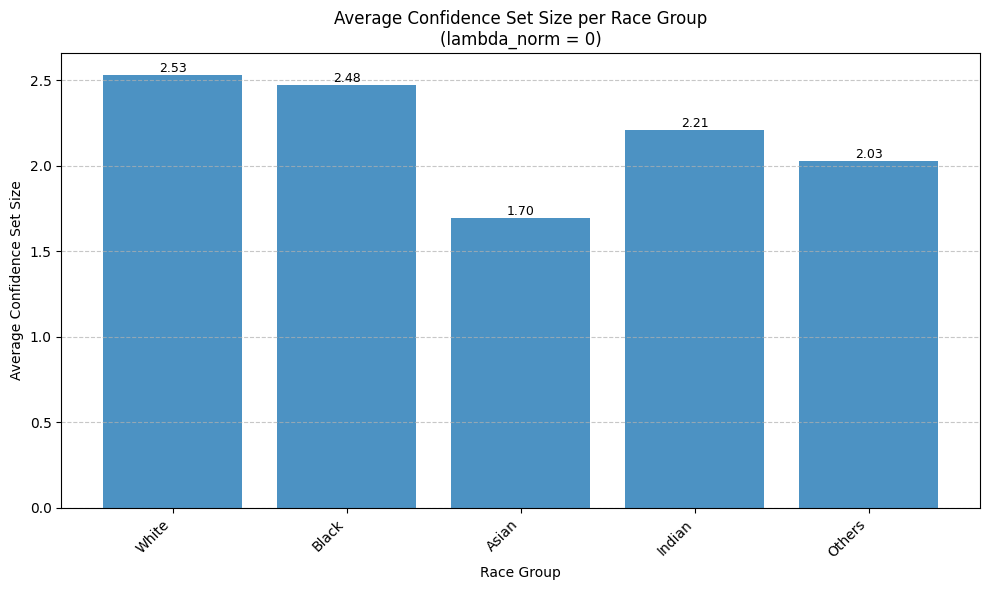

In [36]:
for g_id in RACE_GROUPS.keys():
    group_set_sizes = [pt['per_group_avg_set_size'].get(g_id, float('nan')) for pt in trade_off_points][0]
    print(group_set_sizes)

import matplotlib.pyplot as plt
import numpy as np

avg_set_sizes = [
    2.5327380952380953,
    2.4751381215469612,
    1.6972343522561864,
    2.208805031446541,
    2.026627218934911
]

group_labels = ["White", "Black", "Asian", "Indian", "Others"]
plt.figure(figsize=(10, 6))

bars = plt.bar(group_labels, avg_set_sizes, color='#1f77b4', alpha=0.8)

plt.xlabel("Race Group")
plt.ylabel("Average Confidence Set Size")
plt.title("Average Confidence Set Size per Race Group\n(lambda_norm = 0)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)

min_val = min(avg_set_sizes) if avg_set_sizes else 0
if min_val >= 0:
    plt.ylim(bottom=0)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0,
             yval,
             f'{yval:.2f}',
             ha='center',
             va='bottom',
             fontsize=9,
             color='black')

plt.tight_layout()
plt.show()

# Algorithm 3


--- Implementing Algorithm 3: Fairness-Adjusted PAC Parameters (ε_g) for Age Range Prediction ---
Goal: Iteratively adjust per-group ε_g to try and equalize resulting T_g values, then plot final average set sizes.

Iteration 1/20 for Epsilon_g Adjustment
  Group White: ε_g=0.100 -> k_g=179 -> s_g_thresh=0.1019 -> T_g=2.283
  Group Black: ε_g=0.100 -> k_g=75 -> s_g_thresh=0.1005 -> T_g=2.297
  Group Asian: ε_g=0.100 -> k_g=55 -> s_g_thresh=0.1475 -> T_g=1.914
  Group Indian: ε_g=0.100 -> k_g=65 -> s_g_thresh=0.1223 -> T_g=2.101
  Group Others: ε_g=0.100 -> k_g=24 -> s_g_thresh=0.1088 -> T_g=2.218

--- Evaluation Summary for Alg 3 (Iter 1) ---
        Algorithm    Group  GroupID  Samples (n_g) Coverage AvgSetSize Avg_T_used  k_g (PAC)
0  Alg 3 (Iter 1)    White        0           2016    0.911      2.533      2.283      179.0
1  Alg 3 (Iter 1)    Black        1            905    0.917      2.476      2.297       75.0
2  Alg 3 (Iter 1)    Asian        2            687    0.920      1.697

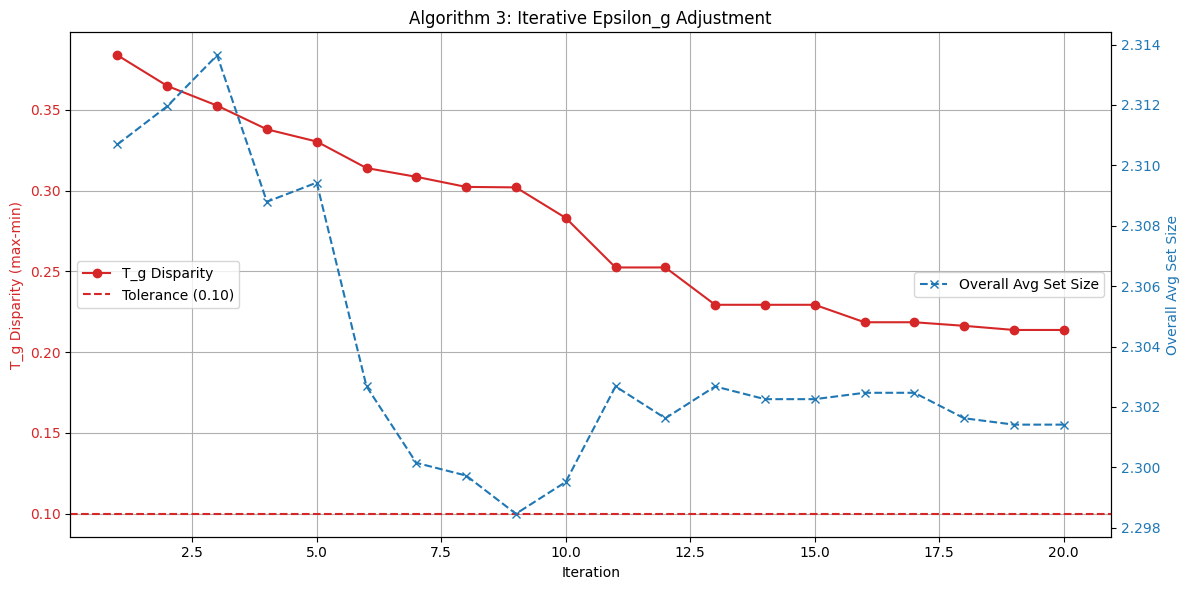

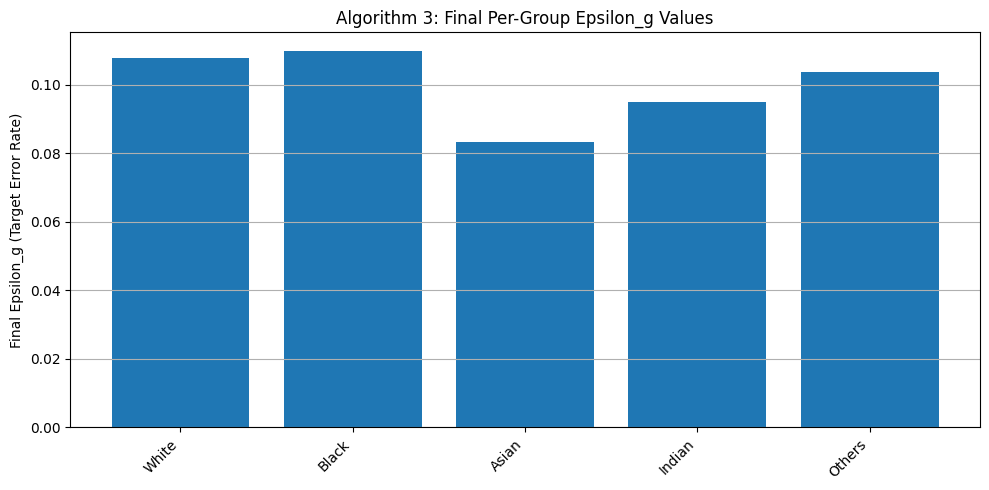

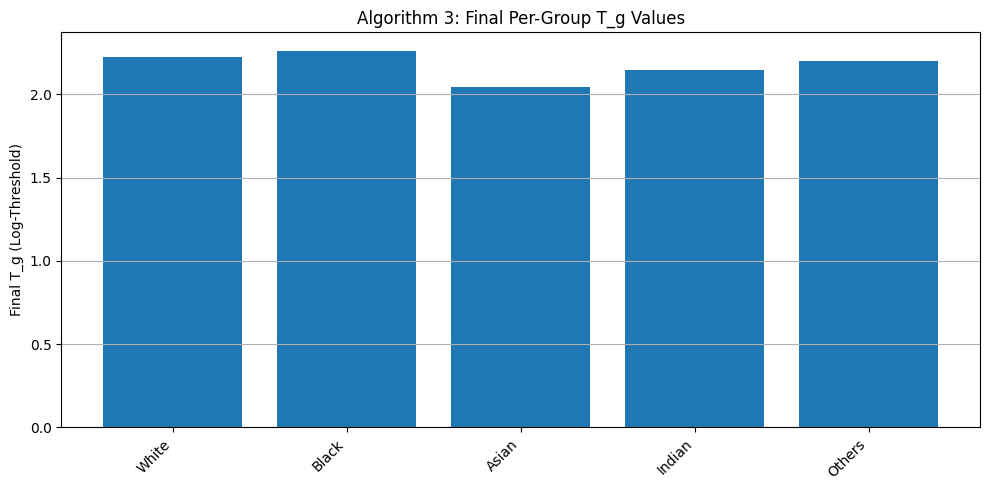

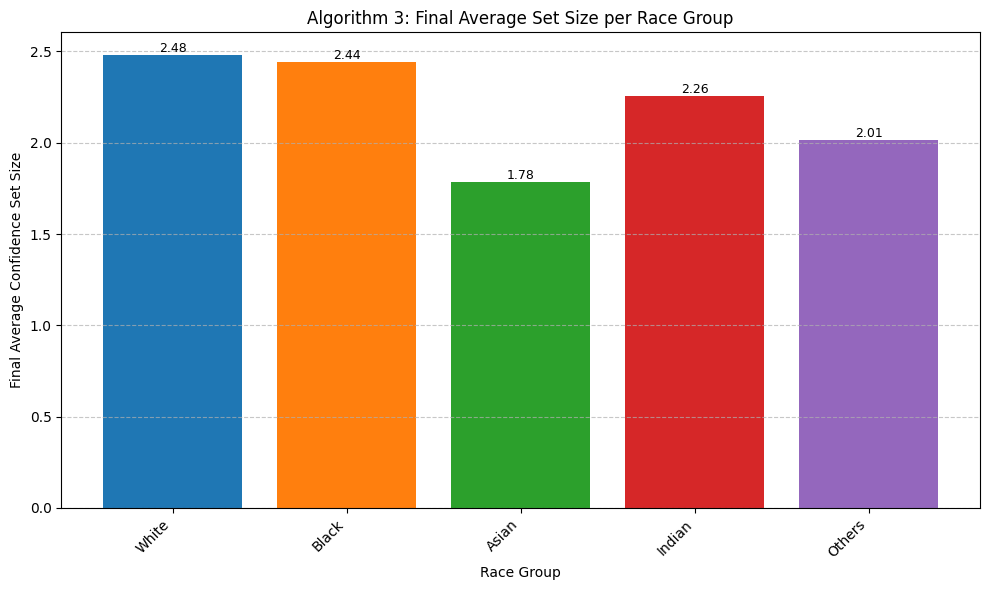


Final State from Algorithm 3 Epsilon_g Adjustment:
     iteration  T_g_disparity  T_g_mean  overall_avg_set_size  \
19         20       0.213729  2.174931              2.301413   

                                     epsilon_g_values  \
19  {0: 0.1079034161684224, 1: 0.10985382228960011...   

                                           T_g_values  \
19  {0: 2.2217730157531523, 1: 2.2586252169097496,...   

                              k_g_values  \
19  {0: 194, 1: 83, 2: 45, 3: 61, 4: 25}   

                              per_group_avg_set_sizes  
19  {0: 2.480654761904762, 1: 2.4408839779005524, ...  

--- Algorithm 3 (Fairness-Adjusted Epsilon_g) Focused Script Finished ---


In [31]:
N_ITERATIONS_EPS_ADJUST = 20
EPS_LEARNING_RATE = 0.005
MIN_EPSILON_G = 0.01
MAX_EPSILON_G = 0.50
DISPARITY_TOLERANCE_TG = 0.1

active_groups_for_eps_adj = [gid for gid in RACE_GROUPS.keys() if per_group_n_g.get(gid, 0) > 0]
current_epsilon_g_values = {gid: EPSILON_PAC for gid in active_groups_for_eps_adj}

if not active_groups_for_eps_adj:
    print("No active groups with samples in Z_val to adjust epsilon_g for. Skipping Algorithm 3.")
    history_alg3 = []
else:
    history_alg3 = []

    for iteration in range(N_ITERATIONS_EPS_ADJUST):
        print(f"\nIteration {iteration + 1}/{N_ITERATIONS_EPS_ADJUST} for Epsilon_g Adjustment")
        current_T_g_iteration = {}
        current_s_g_thresholds_iteration = {}
        current_k_g_iteration = {}

        for group_id in active_groups_for_eps_adj:
            n_g = per_group_n_g[group_id]
            epsilon_g = current_epsilon_g_values[group_id]
            k_g = compute_k_star_for_group(n_g, epsilon_g, DELTA_PAC)
            current_k_g_iteration[group_id] = k_g

            if k_g == -1:
                current_T_g_iteration[group_id], current_s_g_thresholds_iteration[group_id] = float('inf'), 0.0
                print(f"  Group {RACE_GROUPS.get(group_id, group_id)}: k_g=-1 (ε_g={epsilon_g:.3f}). T_g=inf.")
                continue

            group_g_indices = [i for i, r_label in enumerate(conf_set_val_dataset.race_labels) if r_label == group_id]
            g_files = [conf_set_val_dataset.image_files[i] for i in group_g_indices]
            g_targets = [conf_set_val_dataset.age_class_labels[i] for i in group_g_indices]
            g_races = [conf_set_val_dataset.race_labels[i] for i in group_g_indices]

            temp_dset = UTKFaceAgeRaceDataset(transform=common_transform,
                                                 file_list=g_files, age_class_labels=g_targets, race_labels=g_races)

            b_size = min(BATCH_SIZE, n_g) if n_g > 0 else 1
            temp_loader = DataLoader(temp_dset, batch_size=b_size, shuffle=False)

            scores_true_g = get_calibrated_scores_for_true_labels_on_z_val(
                model_phi, temp_loader, temp_scaler_obj, OPTIMIZED_TAU
            )

            if not scores_true_g.size:
                current_T_g_iteration[group_id], current_s_g_thresholds_iteration[group_id] = float('inf'), 0.0
                continue

            sorted_scores_g = np.sort(scores_true_g)
            idx_thresh = k_g
            if idx_thresh >= n_g: idx_thresh = n_g - 1

            final_idx_thresh = idx_thresh
            if n_g > 1:
                 while final_idx_thresh > 0 and np.isclose(sorted_scores_g[final_idx_thresh], sorted_scores_g[final_idx_thresh - 1]):
                    final_idx_thresh -= 1

            s_g_thresh = sorted_scores_g[final_idx_thresh]
            current_s_g_thresholds_iteration[group_id] = s_g_thresh
            current_T_g_iteration[group_id] = -math.log(s_g_thresh) if s_g_thresh > 0 else float('inf')
            print(f"  Group {RACE_GROUPS.get(group_id, group_id)}: ε_g={epsilon_g:.3f} -> k_g={k_g} -> s_g_thresh={s_g_thresh:.4f} -> T_g={current_T_g_iteration[group_id]:.3f}")

        valid_T_g_iter = [t for gid, t in current_T_g_iteration.items() if gid in active_groups_for_eps_adj and not np.isinf(t) and not np.isnan(t)]
        if not valid_T_g_iter:
            print("  No valid T_g values in this iteration. Stopping.")
            break

        T_g_disparity_iter = max(valid_T_g_iter) - min(valid_T_g_iter) if len(valid_T_g_iter) >= 2 else 0.0
        T_g_mean_iter = np.mean(valid_T_g_iter)

        eval_threshold_map_iter = {gid: 0.0 for gid in RACE_GROUPS.keys()}
        eval_threshold_map_iter.update(current_s_g_thresholds_iteration)

        if 'NUM_AGE_CLASSES' not in globals():
            print("ERROR: NUM_AGE_CLASSES is not defined globally. Please define it (e.g., based on AGE_BINS).")
            # Fallback or exit
            num_prediction_classes_for_eval_alg3 = 10
        else:
            num_prediction_classes_for_eval_alg3 = NUM_AGE_CLASSES


        results_iter, _ = evaluate_confidence_sets(
            model_phi, conf_set_val_loader, temp_scaler_obj, OPTIMIZED_TAU,
            eval_threshold_map_iter,
            num_pred_classes=num_prediction_classes_for_eval_alg3,
            algorithm_name=f"Alg 3 (Iter {iteration+1})"
        )
        overall_avg_set_size_iter = results_iter['overall']['avg_set_size'] if results_iter and 'overall' in results_iter else float('nan')

        per_group_avg_set_sizes_iter = {}
        if results_iter:
            for group_id_hist in active_groups_for_eps_adj:
                if group_id_hist in results_iter and 'avg_set_size' in results_iter[group_id_hist]:
                    per_group_avg_set_sizes_iter[group_id_hist] = results_iter[group_id_hist]['avg_set_size']
                else:
                    per_group_avg_set_sizes_iter[group_id_hist] = float('nan')

        history_alg3.append({
            "iteration": iteration + 1, "T_g_disparity": T_g_disparity_iter, "T_g_mean": T_g_mean_iter,
            "overall_avg_set_size": overall_avg_set_size_iter,
            "epsilon_g_values": {gid: current_epsilon_g_values.get(gid) for gid in active_groups_for_eps_adj},
            "T_g_values": {gid: current_T_g_iteration.get(gid) for gid in active_groups_for_eps_adj},
            "k_g_values": {gid: current_k_g_iteration.get(gid) for gid in active_groups_for_eps_adj},
            "per_group_avg_set_sizes": per_group_avg_set_sizes_iter.copy()
        })
        print(f"  Iter {iteration+1} Summary: T_g Disparity={T_g_disparity_iter:.3f}, Mean T_g={T_g_mean_iter:.3f}, OverallAvgSetSize={overall_avg_set_size_iter:.3f}")

        if T_g_disparity_iter < DISPARITY_TOLERANCE_TG or iteration == N_ITERATIONS_EPS_ADJUST - 1:
            stop_reason = "Disparity Tolerance Met" if T_g_disparity_iter < DISPARITY_TOLERANCE_TG else "Max Iterations Reached"
            print(f"  Stopping: {stop_reason}.")
            break

        target_T_adj = T_g_mean_iter
        for group_id in active_groups_for_eps_adj:
            T_g = current_T_g_iteration.get(group_id)
            if T_g is None or np.isinf(T_g) or np.isnan(T_g): continue

            adjustment_direction = T_g - target_T_adj
            current_epsilon_g_values[group_id] += EPS_LEARNING_RATE * adjustment_direction
            current_epsilon_g_values[group_id] = max(MIN_EPSILON_G, min(MAX_EPSILON_G, current_epsilon_g_values[group_id]))

if history_alg3:
    df_history_alg3 = pd.DataFrame(history_alg3)
    if not df_history_alg3.empty:
        fig, ax1 = plt.subplots(figsize=(12, 6))
        color = 'tab:red'; ax1.set_xlabel('Iteration'); ax1.set_ylabel('T_g Disparity (max-min)', color=color)
        ax1.plot(df_history_alg3['iteration'], df_history_alg3['T_g_disparity'], color=color, marker='o', label='T_g Disparity')
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.axhline(y=DISPARITY_TOLERANCE_TG, color=color, linestyle='--', label=f'Tolerance ({DISPARITY_TOLERANCE_TG:.2f})')
        ax1.legend(loc='center left'); ax1.grid(True)

        ax2 = ax1.twinx(); color = 'tab:blue'
        ax2.set_ylabel('Overall Avg Set Size', color=color)
        ax2.plot(df_history_alg3['iteration'], df_history_alg3['overall_avg_set_size'], color=color, marker='x', linestyle='--', label='Overall Avg Set Size')
        ax2.tick_params(axis='y', labelcolor=color); ax2.legend(loc='center right')
        plt.title('Algorithm 3: Iterative Epsilon_g Adjustment'); fig.tight_layout(); plt.show()

        final_eps_g_vals_dict = df_history_alg3.iloc[-1]['epsilon_g_values']
        active_gids_plot_eps = [gid for gid in active_groups_for_eps_adj if final_eps_g_vals_dict.get(gid) is not None]
        if active_gids_plot_eps:
            plt.figure(figsize=(10,5))
            plt.bar([RACE_GROUPS.get(gid,gid) for gid in active_gids_plot_eps], [final_eps_g_vals_dict[gid] for gid in active_gids_plot_eps])
            plt.ylabel("Final Epsilon_g (Target Error Rate)")
            plt.title("Algorithm 3: Final Per-Group Epsilon_g Values")
            plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.grid(axis='y'); plt.show()

        final_T_g_vals_dict = df_history_alg3.iloc[-1]['T_g_values']
        active_gids_plot_T = [gid for gid in active_groups_for_eps_adj if not (np.isinf(final_T_g_vals_dict.get(gid, float('inf'))) or np.isnan(final_T_g_vals_dict.get(gid, float('nan'))))]
        if active_gids_plot_T:
            plt.figure(figsize=(10,5))
            plt.bar([RACE_GROUPS.get(gid,gid) for gid in active_gids_plot_T], [final_T_g_vals_dict[gid] for gid in active_gids_plot_T])
            plt.ylabel("Final T_g (Log-Threshold)"); plt.title("Algorithm 3: Final Per-Group T_g Values")
            plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.grid(axis='y'); plt.show()

        final_iteration_data_alg3 = df_history_alg3.iloc[-1]
        if 'per_group_avg_set_sizes' in final_iteration_data_alg3:
            final_per_group_avg_set_sizes_alg3 = final_iteration_data_alg3['per_group_avg_set_sizes']

            plot_group_names_set_size_alg3 = []
            plot_avg_set_sizes_alg3 = []

            for group_id_plot in sorted(RACE_GROUPS.keys()):
                group_name_plot = RACE_GROUPS.get(group_id_plot, str(group_id_plot))
                avg_set_size_val = final_per_group_avg_set_sizes_alg3.get(group_id_plot, float('nan'))

                if group_id_plot in active_groups_for_eps_adj:
                    plot_group_names_set_size_alg3.append(group_name_plot)
                    plot_avg_set_sizes_alg3.append(avg_set_size_val if not np.isnan(avg_set_size_val) else 0)

            if plot_group_names_set_size_alg3:
                plt.figure(figsize=(10, 6))
                bars_final_set_size = plt.bar(plot_group_names_set_size_alg3, plot_avg_set_sizes_alg3,
                                              color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])

                plt.xlabel(f"{SENSITIVE_ATTR_NAME} Group")
                plt.ylabel("Final Average Confidence Set Size")
                plt.title(f"Algorithm 3: Final Average Set Size per {SENSITIVE_ATTR_NAME} Group")
                plt.xticks(rotation=45, ha="right"); plt.grid(axis='y', linestyle='--', alpha=0.7)

                min_plotted_val = min(s for s in plot_avg_set_sizes_alg3 if not np.isnan(s)) if any(not np.isnan(s) for s in plot_avg_set_sizes_alg3) else 0
                if min_plotted_val >= 0: plt.ylim(bottom=0)

                for bar in bars_final_set_size:
                    yval = bar.get_height()
                    if not np.isnan(yval):
                        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}',
                                 ha='center', va='bottom', fontsize=9)
                plt.tight_layout(); plt.show()
            else: print("No valid final per-group average set size data to plot for Algorithm 3.")
        else: print("Plotting final avg set sizes skipped: 'per_group_avg_set_sizes' not found in last history item.")

        print("\nFinal State from Algorithm 3 Epsilon_g Adjustment:\n", pd.DataFrame([df_history_alg3.iloc[-1]]))
    else:
        print("History for Algorithm 3 is empty, skipping plots.")

print("\n--- Algorithm 3 (Fairness-Adjusted Epsilon_g) Focused Script Finished ---")